# Lista 2

In [12]:
import sys
sys.path.append('..')
from fractions import Fraction

from IPython.display import display, Math
import numpy as np
import pandas as pd
from scipy.stats import binom
from scipy.integrate import simpson, cumulative_trapezoid
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from utils.math import quantile

## Questão 1

## Questão 2

### a)

Quando o dado não é enviesado, a verossimilhança em $y$ é dada por

\begin{align*}
\mathbb{P}(y) &= \sum_{\theta_i \in \Omega(\theta)} \mathbb{P}(y | \theta = \theta_i, I) \mathbb{P}(\theta = \theta_i | I)\\
&= \mathbb{P}(y | \theta = 1/6, I)\\
& \sim \text{Binom}(y, 1/6)
\end{align*}

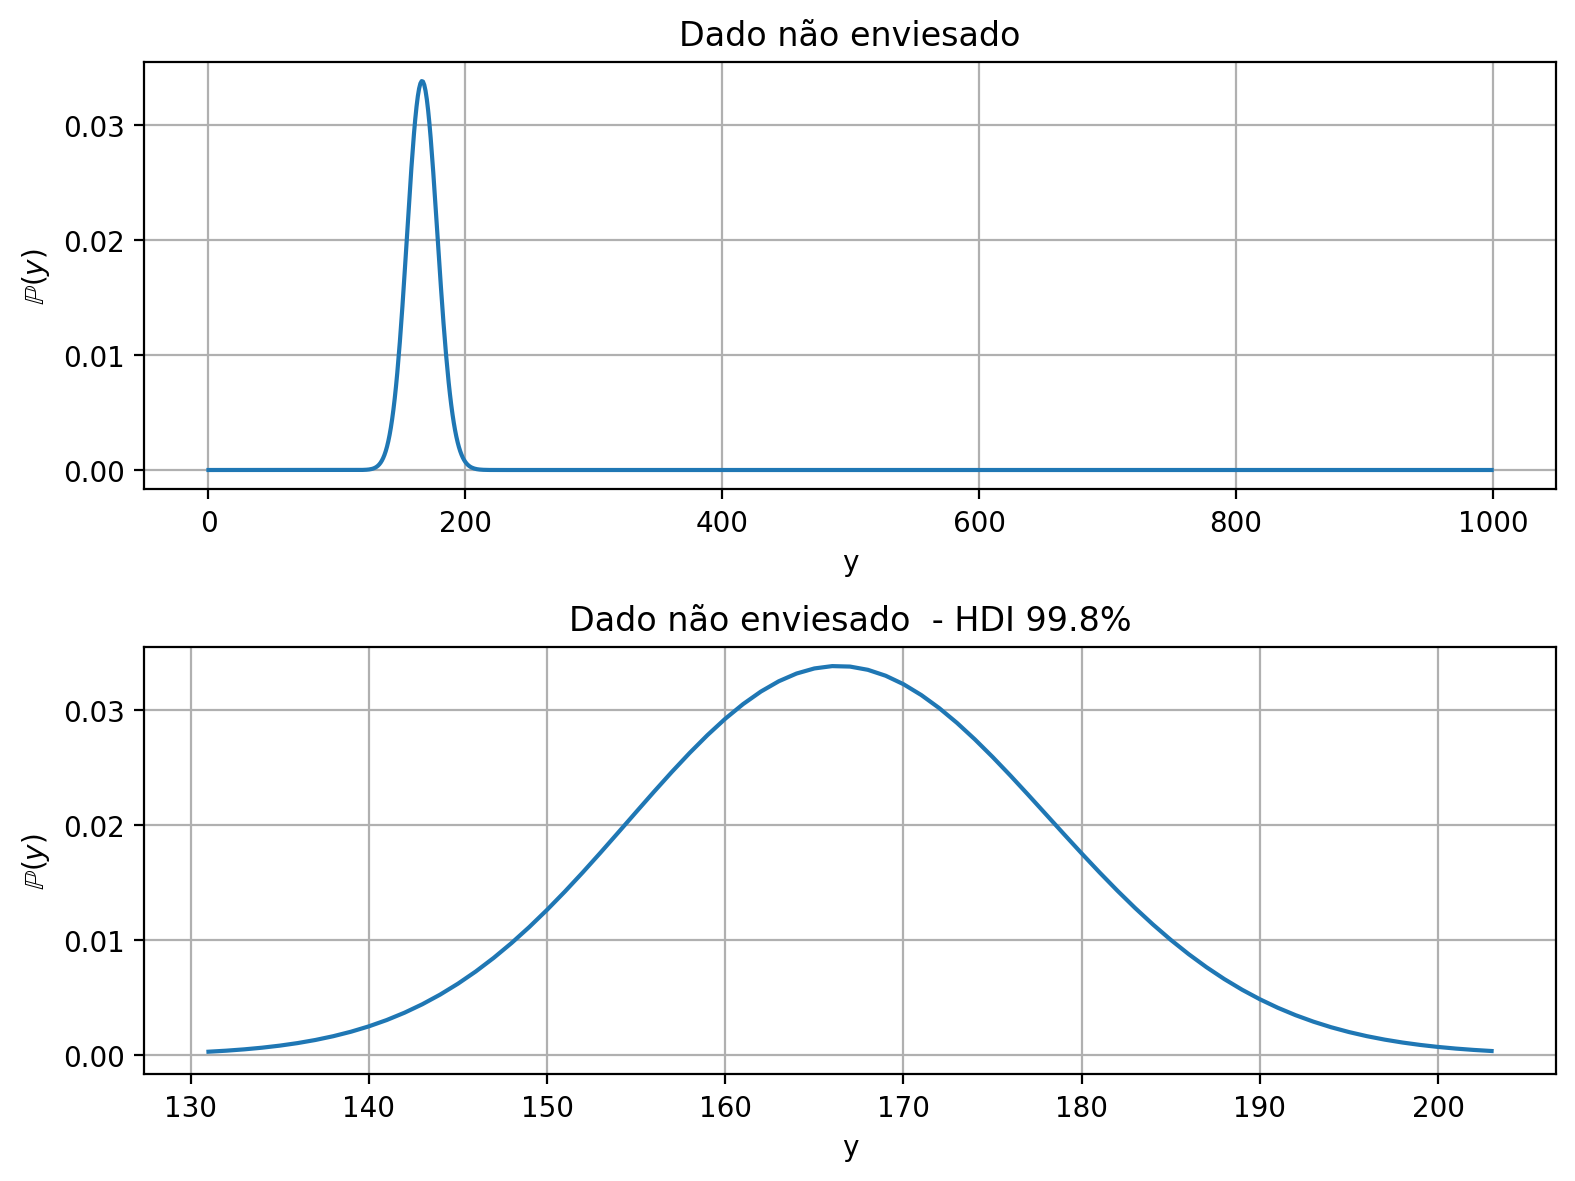

In [13]:
n = 1000
p = 1 / 6
y = np.arange(n)
zoomed_y = np.arange(binom.ppf(0.001, n, p), binom.ppf(0.999, n, p))
fig, axs = plt.subplots(2, 1, sharey=True, figsize=(8, 6))
axs[0].plot(y, binom.pmf(y, n, p))
axs[1].plot(zoomed_y, binom.pmf(zoomed_y, n, p))
for ax in axs:
    ax.grid()
    ax.set_xlabel('y')
    ax.set_ylabel(r'$\mathbb{P}(y)$')
axs[0].set_title('Dado não enviesado')
axs[1].set_title('Dado não enviesado  - HDI 99.8%')
fig.tight_layout()
plt.show()

In [14]:
qs = [0.05, 0.25, 0.50, 0.75, 0.95]
quantiles = quantile(binom.pmf(y, n, p), y, qs, discrete=True)
theo_quantiles = binom.ppf(qs, n, p)
# Compare quantile computation with theoretical given by scipy.stats.binom.ppf
assert any(abs(quantiles - theo_quantiles) < 1e-3)

for pq, q in zip(qs, quantiles):
    display(Math(r'\mathbb{P}(y \leq q) = ' + r'{0} \Rightarrow q = {1:.2f}'.format(pq, q)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### b)

\begin{align*}
\mathbb{P}(y) &= \sum_{\theta_i \in \Omega(\theta)} \mathbb{P}(y | \theta = \theta_i, I) \mathbb{P}(\theta = \theta_i | I)\\
&= \mathbb{P}(y | \theta = 1 / 12, I) \mathbb{P}(\theta = 1/ 12 | I) + \mathbb{P}(y | \theta = 1 / 6, I) \mathbb{P}(\theta = 1/ 6 | I) + \mathbb{P}(y | \theta = 1 / 4, I) \mathbb{P}(\theta = 1/ 4 | I)\\
&= 0.25\mathbb{P}(y | \theta = 1 / 12, I) + 0.5\mathbb{P}(y | \theta = 1 / 6, I) + 0.25\mathbb{P}(y | \theta = 1 / 4, I)
\end{align*}

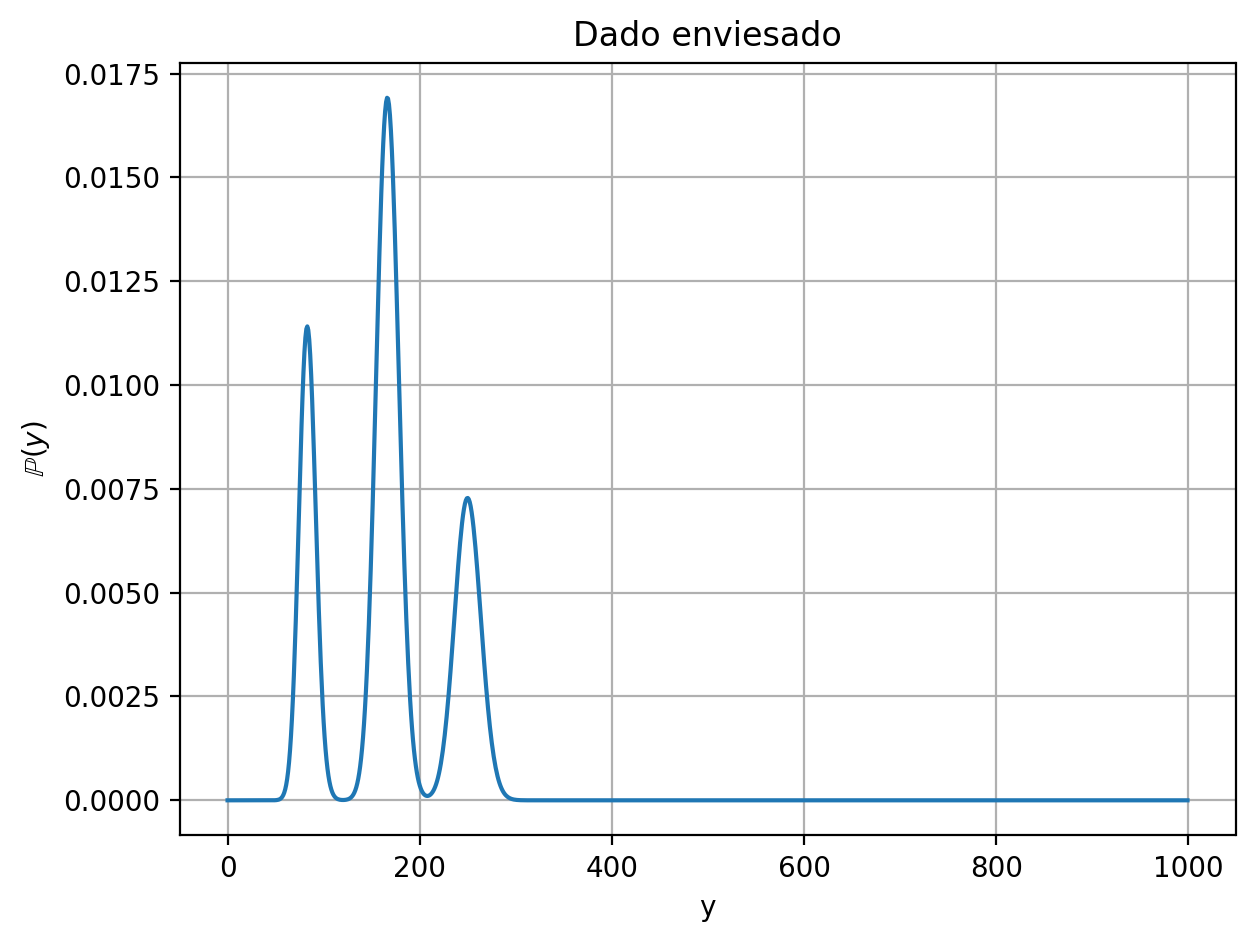

In [15]:
n = 1000
y = np.arange(n)
def pmf(k, n):
    return 0.25 * binom.pmf(k, n, 1 / 12) + 0.5 * binom.pmf(k, n, 1 / 6) + 0.25 * binom.pmf(k, n, 1 / 4)

fig, ax = plt.subplots()
ax.plot(y, pmf(y, n))
ax.set_xlabel('y')
ax.set_ylabel(r'$\mathbb{P}(y)$')
ax.set_title('Dado enviesado')
ax.grid()
fig.tight_layout()
plt.show()

In [16]:
qs = [0.05, 0.25, 0.50, 0.75, 0.95]
quantiles = quantile(pmf(y, n), y, qs, discrete=True)

for pq, q in zip(qs, quantiles):
    display(Math(r'\mathbb{P}(y \leq q) = ' + r'{0} \Rightarrow q = {1:.2f}'.format(pq, q)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Questão 3